# Feature engineering on bureau and bureau_balance datasets

Based on Will Koehrsen's and Shanth Kaggle Notebooks, availiable at: 
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
- https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering

In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Options
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Bureau

In [2]:
# Importing datasets
df_bureau = pd.read_csv('../data/data_inputs/bureau.csv')
df_app = pd.read_pickle('../data/data_outputs/feature_engineered/application.pkl')

In [3]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


## Number of previous loans

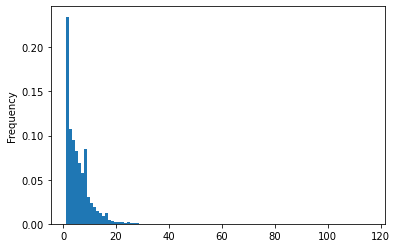

count    305811.000000
mean          5.612709
std           4.430354
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         116.000000
Name: SK_ID_BUREAU, dtype: float64

In [4]:
# Distribution of previous loans
count_loans = df_bureau.groupby('SK_ID_CURR', as_index = False).agg({'SK_ID_BUREAU' : 'count'})
count_loans['SK_ID_BUREAU'].plot(kind = 'hist', density = 'True', bins = 100)
plt.show()

count_loans['SK_ID_BUREAU'].describe()

In [5]:
# Merge in application dataset
count_loans.rename(columns = {'SK_ID_BUREAU' : 'NB_PREVIOUS_LOANS'}, inplace=True)
df_app = df_app.merge(count_loans, on = 'SK_ID_CURR', how = 'left')
df_app['NB_PREVIOUS_LOANS'].fillna(0, inplace = True)

## Mean number of loans per loan type

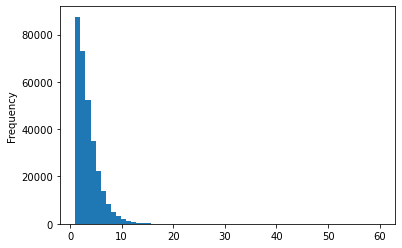

count    305811.000000
mean          3.149719
std           2.212574
min           1.000000
25%           1.500000
50%           2.500000
75%           4.000000
max          60.000000
Name: AVG_LOAN_TYPE, dtype: float64

In [6]:
# Mean number of loans per loan type per customer
grp = df_bureau.groupby('SK_ID_CURR', as_index = False).agg(
    {'SK_ID_BUREAU' : 'count',
     'CREDIT_TYPE' : 'nunique'}
)
grp['AVG_LOAN_TYPE'] = grp['SK_ID_BUREAU']/grp['CREDIT_TYPE']
grp['AVG_LOAN_TYPE'].plot(kind = 'hist', bins = 60)
plt.show()

grp['AVG_LOAN_TYPE'].describe()

In [7]:
# Merge in main dataset
df_app = df_app.merge(grp[['SK_ID_CURR', 'AVG_LOAN_TYPE']], on = 'SK_ID_CURR', how = 'left')
df_app['AVG_LOAN_TYPE'].fillna(0, inplace = True)

## Proportion of active loans

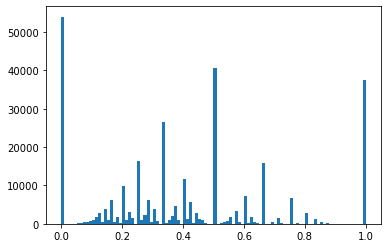

count    305811.000000
mean          0.410223
std           0.307228
min           0.000000
25%           0.200000
50%           0.375000
75%           0.600000
max           1.000000
Name: %_ACTIVE_CREDITS, dtype: float64

In [8]:
# Calculate % of active credits per client
df_bureau['IS_CREDIT_ACTIVE'] =(df_bureau['CREDIT_ACTIVE'] == 'Active')
grp = df_bureau.groupby(by = 'SK_ID_CURR', as_index = False).agg({'IS_CREDIT_ACTIVE' : 'mean'})
grp.rename(columns = {'IS_CREDIT_ACTIVE' : '%_ACTIVE_CREDITS'}, inplace = True)

plt.hist(grp['%_ACTIVE_CREDITS'], bins = 100)
plt.show()

grp['%_ACTIVE_CREDITS'].describe()

In [9]:
# Merge in main dataset
df_app = df_app.merge(grp, on = 'SK_ID_CURR', how = 'left')
df_app['%_ACTIVE_CREDITS'].fillna(0, inplace = True)

## Average number of days between successive applications

In [13]:
grp = df_bureau[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT']].groupby(by = 'SK_ID_CURR')
grp = grp.apply(lambda x: x.sort_values(['DAYS_CREDIT'], ascending = False)).reset_index(drop = True)
grp['DAYS_CREDIT'] = -grp['DAYS_CREDIT']
grp['DAYS_DIFF'] = grp.groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].diff()
grp = grp.groupby(by = ['SK_ID_CURR'], as_index = False).agg({'DAYS_DIFF' : 'mean'})

In [11]:
# Merge in main dataset
grp.rename(columns = {'DAYS_DIFF' : 'MEAN_DAYS_BTW_APPLICATIONS'}, inplace = True)
df_app = df_app.merge(grp, on = 'SK_ID_CURR', how = 'left')

## Debt over credit ration

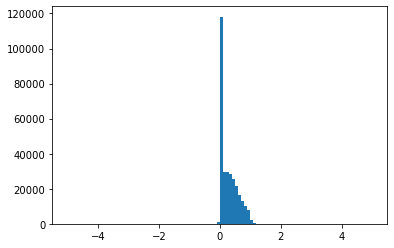

count    304535.000000
mean          0.282770
std           0.291676
min          -5.000000
25%           0.000000
50%           0.210886
75%           0.481842
max           5.000000
Name: DEBT_CREDIT_RATIO, dtype: float64

In [30]:
# Calculation
df_bureau['AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
df_bureau['AMT_CREDIT_SUM'] = df_bureau['AMT_CREDIT_SUM'].fillna(0)

grp = df_bureau.groupby(by = 'SK_ID_CURR', as_index = False)[['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM']].sum()
grp['DEBT_CREDIT_RATIO'] = grp['AMT_CREDIT_SUM_DEBT'] / grp['AMT_CREDIT_SUM']
grp['DEBT_CREDIT_RATIO'] = grp['DEBT_CREDIT_RATIO'].replace(np.inf, np.nan)
grp['DEBT_CREDIT_RATIO'] = grp['DEBT_CREDIT_RATIO'].replace(-np.inf, np.nan)
grp['DEBT_CREDIT_RATIO'] = np.clip(grp['DEBT_CREDIT_RATIO'], -5, 5)

plt.hist(grp['DEBT_CREDIT_RATIO'], bins = 100)
plt.show()
grp['DEBT_CREDIT_RATIO'].describe()

In [32]:
# Merge in main dataset
df_app = df_app.merge(grp[['SK_ID_CURR', 'DEBT_CREDIT_RATIO']], on = 'SK_ID_CURR', how = 'left')

## Overdue over debt ratio

In [46]:
# Calculation
df_bureau['AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
df_bureau['AMT_CREDIT_SUM_OVERDUE'] = df_bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)

grp = df_bureau.groupby('SK_ID_CURR', as_index = False)[['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE']].sum()
grp['OVERDUE_DEBT_RATIO'] = grp['AMT_CREDIT_SUM_OVERDUE']/grp['AMT_CREDIT_SUM_DEBT']

In [48]:
# Merge in main dataset
df_app = df_app.merge(grp[['SK_ID_CURR', 'OVERDUE_DEBT_RATIO']], on = 'SK_ID_CURR', how = 'left')

## Mean number of times a loan was prolonged

In [49]:
# Calculation
df_bureau['CNT_CREDIT_PROLONG'] = df_bureau['CNT_CREDIT_PROLONG'].fillna(0)
grp = df_bureau.groupby('SK_ID_CURR', as_index = False)['CNT_CREDIT_PROLONG'].mean()

In [56]:
# Merge
grp.rename(columns = {'CNT_CREDIT_PROLONG' : 'AVG_CNT_PROLONGED'}, inplace = True)
df_app = df_app.merge(grp, on = 'SK_ID_CURR', how = 'left')
df_app['AVG_CNT_PROLONGED'] = df_app['AVG_CNT_PROLONGED'].fillna(0)

In [60]:
df_app

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,...,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,source,DAYS_EMPLOYED_ANOM,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_3^2,EXT_SOURCE_3 DAYS_BIRTH,DAYS_BIRTH^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 EXT_SOURCE_2,EXT_SOURCE_1^2 EXT_SOURCE_3,EXT_SOURCE_1^2 DAYS_BIRTH,EXT_SOURCE_1 EXT_SOURCE_2^2,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_S